Accuracy: 1.0000
1.0
Confusion Matrix:
[[19  0]
 [ 0 21]]


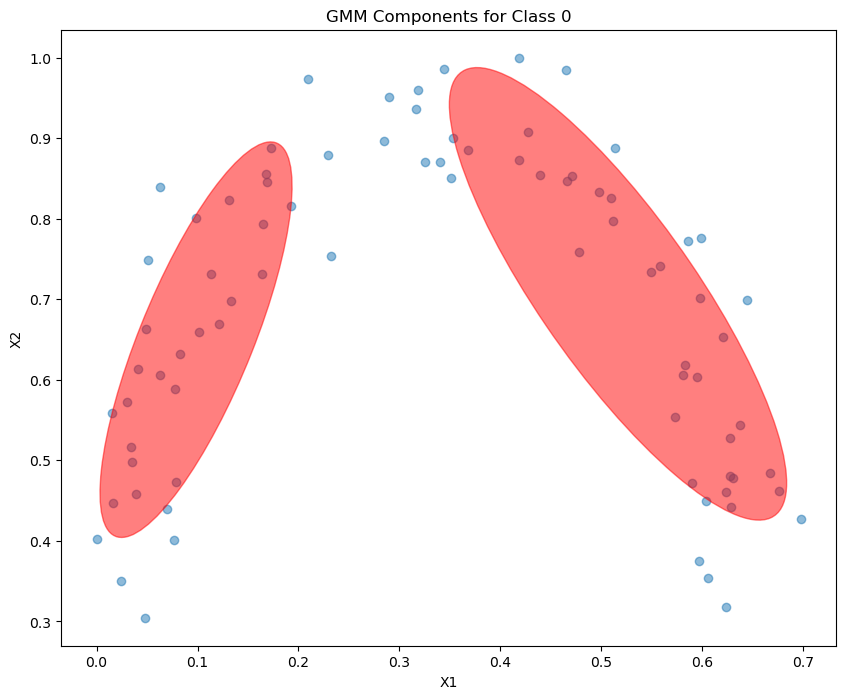

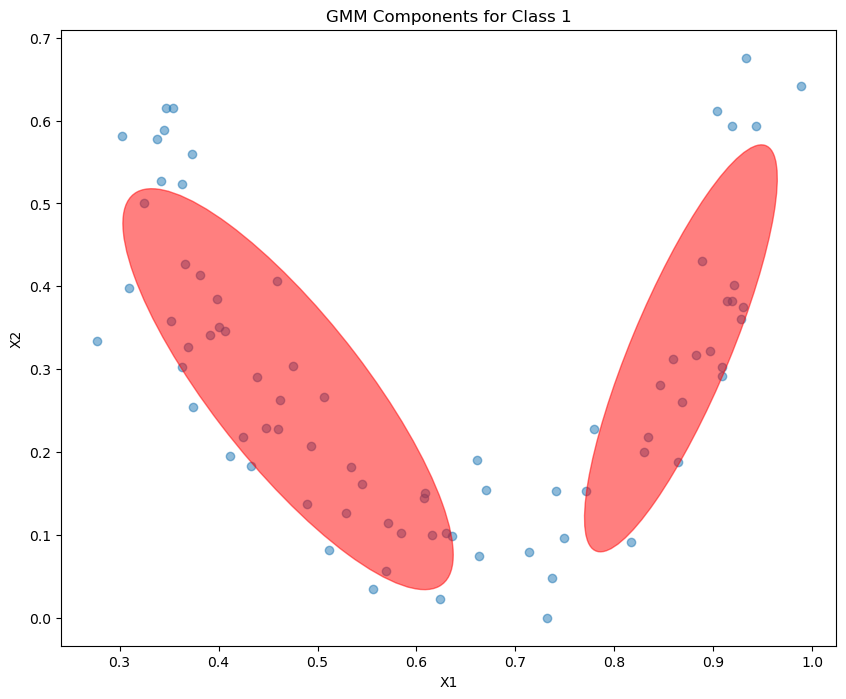

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the data
data = pd.read_csv('datasets/moonDataset.csv')

df_normalized = (data - data.min()) / (data.max() - data.min())

data= df_normalized
X = data[['X1', 'X2', 'X3']].values
y = data['label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class GaussianMixture:
    def __init__(self, n_components, n_features, max_iter=100, tol=1e-3):
        self.n_components = n_components
        self.n_features = n_features
        self.max_iter = max_iter
        self.tol = tol
        
    def initialize_parameters(self, X):
        n_samples = X.shape[0]
        self.weights = np.ones(self.n_components) / self.n_components
        self.means = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances = np.array([np.eye(self.n_features)] * self.n_components)
        
    def gaussian_pdf(self, X, mean, cov):
        n = X.shape[1]
        diff = X - mean
        return np.exp(-0.5 * np.sum(np.dot(diff, np.linalg.inv(cov)) * diff, axis=1)) / np.sqrt((2 * np.pi)**n * np.linalg.det(cov))
    
    def expectation_step(self, X):
        weighted_likelihood = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            weighted_likelihood[:, k] = self.weights[k] * self.gaussian_pdf(X, self.means[k], self.covariances[k])
        return weighted_likelihood / weighted_likelihood.sum(axis=1, keepdims=True)
    
    def maximization_step(self, X, responsibilities):
        total_resp = responsibilities.sum(axis=0)
        self.weights = total_resp / X.shape[0]
        self.means = np.dot(responsibilities.T, X) / total_resp[:, np.newaxis]
        for k in range(self.n_components):
            diff = X - self.means[k]
            self.covariances[k] = np.dot(responsibilities[:, k] * diff.T, diff) / total_resp[k]
    
    def fit(self, X):
        self.initialize_parameters(X)
        
        for _ in range(self.max_iter):
            prev_log_likelihood = self.log_likelihood(X)
            responsibilities = self.expectation_step(X)
            self.maximization_step(X, responsibilities)
            curr_log_likelihood = self.log_likelihood(X)
            
            if np.abs(curr_log_likelihood - prev_log_likelihood) < self.tol:
                break
    
    def log_likelihood(self, X):
        weighted_likelihood = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            weighted_likelihood[:, k] = self.weights[k] * self.gaussian_pdf(X, self.means[k], self.covariances[k])
        return np.sum(np.log(weighted_likelihood.sum(axis=1)))
    
    def predict(self, X):
        responsibilities = self.expectation_step(X)
        return np.argmax(responsibilities, axis=1)

# Train GMMs for each class
gmm_class_0 = GaussianMixture(n_components=2, n_features=3)
gmm_class_1 = GaussianMixture(n_components=2, n_features=3)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]

gmm_class_0.fit(X_train_0)
gmm_class_1.fit(X_train_1)

# Predict on test set
def predict_gmm(X):
    log_likelihood_0 = np.array([gmm_class_0.log_likelihood(x.reshape(1, -1)) for x in X])
    log_likelihood_1 = np.array([gmm_class_1.log_likelihood(x.reshape(1, -1)) for x in X])
    return (log_likelihood_1 > log_likelihood_0).astype(int)

y_pred = predict_gmm(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(np.mean(y_pred == y_test))
print("Confusion Matrix:")
print(conf_matrix)

# Visualize the results
def plot_decision_boundary(X, y, gmm_0, gmm_1, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    mesh_points = np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())]
    Z = predict_gmm(mesh_points)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.show()

# plot_decision_boundary(X, y, gmm_class_0, gmm_class_1, "GMM Decision Boundary")

# Plot GMM components
def plot_gmm_components(X, gmm, title):
    plt.figure(figsize=(10, 8))
    plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
    
    for k in range(gmm.n_components):
        mean = gmm.means[k][:2]
        cov = gmm.covariances[k][:2, :2]
        v, w = np.linalg.eigh(cov)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        
        angle = np.arctan2(u[1], u[0])
        angle = 180. * angle / np.pi
        
        ell = plt.matplotlib.patches.Ellipse(xy=mean, width=v[0], height=v[1], angle=angle, color='r')
        ell.set_clip_box(plt.gca().bbox)
        ell.set_alpha(0.5)
        plt.gca().add_artist(ell)
    
    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.show()

plot_gmm_components(X_train_0, gmm_class_0, "GMM Components for Class 0")
plot_gmm_components(X_train_1, gmm_class_1, "GMM Components for Class 1")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the data
data = pd.read_csv('datasets/moonDataset.csv')
df_normalized = (data - data.min()) / (data.max() - data.min())

data= df_normalized

# Perform PCA
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data)

data_pca

array([[ 0.50843472,  0.34961047,  0.43040455],
       [ 0.67869504,  0.26276082,  0.29013516],
       [ 0.59443545,  0.4138361 , -0.11217085],
       [-0.36843619,  0.38421028,  0.28847274],
       [-0.47792404, -0.42548293,  0.19184416],
       [ 0.66611855, -0.05879382, -0.08013687],
       [ 0.55871388,  0.07465353, -0.20189969],
       [-0.61461669, -0.32492395,  0.14162054],
       [ 0.66231404,  0.06802909, -0.04926584],
       [-0.39329295, -0.34885941,  0.13255513],
       [ 0.39359371, -0.31290344, -0.31607537],
       [ 0.5676983 , -0.20934539,  0.29006854],
       [ 0.38709071,  0.22117764, -0.16213686],
       [-0.50664569, -0.06868465,  0.16108485],
       [-0.61468001,  0.16288106, -0.16682177],
       [ 0.6494793 , -0.03610444,  0.09580691],
       [ 0.50003375,  0.0881142 , -0.25467061],
       [-0.64084561,  0.0918837 , -0.22072263],
       [-0.66309034,  0.3613508 , -0.02722383],
       [-0.61428156, -0.05842965, -0.28291787],
       [-0.58388053, -0.01001217, -0.258

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the data
data = pd.read_csv('datasets/moonDataset.csv')
df_normalized = (data - data.min()) / (data.max() - data.min())

data= df_normalized

X = data[['X1', 'X2', 'X3']].values
y = data['label'].values
# Perform PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(X,y)



# Standardize the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)


# print(X_pca)
# Implement GMM from scratch
class GMM:
    def __init__(self, n_components, n_iterations=100):
        self.n_components = n_components
        self.n_iterations = n_iterations

    def initialize_parameters(self, X):
        n_samples, n_features = X.shape
        self.weights = np.ones(self.n_components) / self.n_components
        self.means = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances = [np.eye(n_features) for _ in range(self.n_components)]

    def gaussian_pdf(self, X, mean, cov):
        n_features = X.shape[1]
        det = np.linalg.det(cov)
        inv_cov = np.linalg.inv(cov)
        diff = X - mean
        exponent = -0.5 * np.sum(diff.dot(inv_cov) * diff, axis=1)
        normalizer = 1 / (np.sqrt((2 * np.pi) ** n_features * det))
        return normalizer * np.exp(exponent)

    def expectation_step(self, X):
        weighted_likelihoods = np.zeros((X.shape[0], self.n_components))
        for i in range(self.n_components):
            weighted_likelihoods[:, i] = self.weights[i] * self.gaussian_pdf(X, self.means[i], self.covariances[i])
        total_likelihood = np.sum(weighted_likelihoods, axis=1)
        return weighted_likelihoods / total_likelihood[:, np.newaxis]

    def maximization_step(self, X, responsibilities):
        n_samples = X.shape[0]
        self.weights = np.sum(responsibilities, axis=0) / n_samples
        self.means = responsibilities.T.dot(X) / np.sum(responsibilities, axis=0)[:, np.newaxis]
        for i in range(self.n_components):
            diff = X - self.means[i]
            self.covariances[i] = (responsibilities[:, i][:, np.newaxis] * diff).T.dot(diff) / np.sum(responsibilities[:, i])

    def fit(self, X):
        self.initialize_parameters(X)
        for _ in range(self.n_iterations):
            responsibilities = self.expectation_step(X)
            self.maximization_step(X, responsibilities)

    def predict(self, X):
        responsibilities = self.expectation_step(X)
        return np.argmax(responsibilities, axis=1)

# Train the GMM model
gmm = GMM(n_components=2, n_iterations=10000)
gmm.fit(X_pca)

# Make predictions
y_pred = gmm.predict(X_pca)

# Evaluate the model's performance
accuracy = np.mean(y_pred == y)
print(f"Accuracy: {accuracy:.4f}")

# Visualize the results
plt.figure(figsize=(12, 5))

# Plot the original data
plt.subplot(121)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.title("Original Data")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.colorbar(scatter)

# Plot the GMM classification
plt.subplot(122)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis', alpha=0.7)
plt.title("GMM Classification")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.colorbar(scatter)

# Plot decision boundaries
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = gmm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')

plt.tight_layout()
plt.show()

NameError: name 'X_pca' is not defined

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# ... (previous code remains the same)

# def plot_decision_boundary_2d(X, y, gmm_0, gmm_1, title, feature1, feature2):
#     x_min, x_max = X[:, feature1].min() - 1, X[:, feature1].max() + 1
#     y_min, y_max = X[:, feature2].min() - 1, X[:, feature2].max() + 1
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
#                          np.arange(y_min, y_max, 0.1))
    
#     mesh_points = np.zeros((xx.ravel().shape[0], 3))
#     mesh_points[:, feature1] = xx.ravel()
#     mesh_points[:, feature2] = yy.ravel()
    
#     Z = predict_gmm(mesh_points)
#     Z = Z.reshape(xx.shape)
    
#     plt.figure(figsize=(10, 8))
#     plt.contourf(xx, yy, Z, alpha=0.4)
#     plt.scatter(X[:, feature1], X[:, feature2], c=y, alpha=0.8)
#     plt.title(title)
#     plt.xlabel(f"X{feature1+1}")
#     plt.ylabel(f"X{feature2+1}")
#     plt.show()

# Plot decision boundaries for all feature pairs
feature_pairs = [(0, 1), (0, 2), (1, 2)]
for i, j in feature_pairs:
    plot_decision_boundary_2d(X, y, gmm_class_0, gmm_class_1, f"GMM Decision Boundary (X{i+1} vs X{j+1})", i, j)

def plot_gmm_components_2d(X, gmm, title, feature1, feature2):
    plt.figure(figsize=(10, 8))
    plt.scatter(X[:, feature1], X[:, feature2], alpha=0.5)
    
    for k in range(gmm.n_components):
        mean = gmm.means[k][[feature1, feature2]]
        cov = gmm.covariances[k][[feature1, feature2]][:, [feature1, feature2]]
        v, w = np.linalg.eigh(cov)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        
        angle = np.arctan2(u[1], u[0])
        angle = 180. * angle / np.pi
        
        ell = plt.matplotlib.patches.Ellipse(xy=mean, width=v[0], height=v[1], angle=angle, color='r')
        ell.set_clip_box(plt.gca().bbox)
        ell.set_alpha(0.5)
        plt.gca().add_artist(ell)
    
    plt.title(title)
    plt.xlabel(f"X{feature1+1}")
    plt.ylabel(f"X{feature2+1}")
    plt.show()

# Plot GMM components for all feature pairs for both classes
for i, j in feature_pairs:
    plot_gmm_components_2d(X_train_0, gmm_class_0, f"GMM Components for Class 0 (X{i+1} vs X{j+1})", i, j)
    plot_gmm_components_2d(X_train_1, gmm_class_1, f"GMM Components for Class 1 (X{i+1} vs X{j+1})", i, j)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the data
data = pd.read_csv('datasets/moonDataset.csv')

df_normalized = (data - data.min()) / (data.max() - data.min())

data= df_normalized

X = data[['X1', 'X2', 'X3']].values
y = data['label'].values

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print(len(X_pca))
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

class GaussianMixture:
    def __init__(self, n_components, n_features, max_iter=100, tol=1e-3):
        self.n_components = n_components
        self.n_features = n_features
        self.max_iter = max_iter
        self.tol = tol
        
    def initialize_parameters(self, X):
        n_samples = X.shape[0]
        self.weights = np.ones(self.n_components) / self.n_components
        self.means = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances = np.array([np.eye(self.n_features)] * self.n_components)
        
    def gaussian_pdf(self, X, mean, cov):
        n = X.shape[1]
        diff = X - mean
        return np.exp(-0.5 * np.sum(np.dot(diff, np.linalg.inv(cov)) * diff, axis=1)) / np.sqrt((2 * np.pi)**n * np.linalg.det(cov))
    
    def expectation_step(self, X):
        weighted_likelihood = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            weighted_likelihood[:, k] = self.weights[k] * self.gaussian_pdf(X, self.means[k], self.covariances[k])
        return weighted_likelihood / weighted_likelihood.sum(axis=1, keepdims=True)
    
    def maximization_step(self, X, responsibilities):
        total_resp = responsibilities.sum(axis=0)
        self.weights = total_resp / X.shape[0]
        self.means = np.dot(responsibilities.T, X) / total_resp[:, np.newaxis]
        for k in range(self.n_components):
            diff = X - self.means[k]
            self.covariances[k] = np.dot(responsibilities[:, k] * diff.T, diff) / total_resp[k]
    
    def fit(self, X):
        self.initialize_parameters(X)
        
        for _ in range(self.max_iter):
            prev_log_likelihood = self.log_likelihood(X)
            responsibilities = self.expectation_step(X)
            self.maximization_step(X, responsibilities)
            curr_log_likelihood = self.log_likelihood(X)
            
            if np.abs(curr_log_likelihood - prev_log_likelihood) < self.tol:
                break
    
    def log_likelihood(self, X):
        weighted_likelihood = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            weighted_likelihood[:, k] = self.weights[k] * self.gaussian_pdf(X, self.means[k], self.covariances[k])
        return np.sum(np.log(weighted_likelihood.sum(axis=1)))
    
    def predict(self, X):
        responsibilities = self.expectation_step(X)
        return np.argmax(responsibilities, axis=1)

# Train GMMs for each class
gmm_class_0 = GaussianMixture(n_components=2, n_features=2)
gmm_class_1 = GaussianMixture(n_components=2, n_features=2)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]

gmm_class_0.fit(X_train_0)
gmm_class_1.fit(X_train_1)

# Predict on test set
def predict_gmm(X):
    log_likelihood_0 = np.array([gmm_class_0.log_likelihood(x.reshape(1, -1)) for x in X])
    log_likelihood_1 = np.array([gmm_class_1.log_likelihood(x.reshape(1, -1)) for x in X])
    return (log_likelihood_1 > log_likelihood_0).astype(int)

y_pred = predict_gmm(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(np.mean(y_pred == y_test))
print("Confusion Matrix:")
print(conf_matrix)

# Visualize the results
def plot_decision_boundary(X, y, gmm_0, gmm_1, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # Create meshgrid points in 2D (matching the PCA-reduced data)
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    
    # Predict the class for each point in the meshgrid
    Z = predict_gmm(mesh_points)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.show()

plot_decision_boundary(X_train, y_train, gmm_class_0, gmm_class_1, "GMM Decision Boundary")

plot_decision_boundary(X_test, y_test, gmm_class_0, gmm_class_1, "GMM Decision Boundary")

# Plot GMM components
def plot_gmm_components(X, gmm, title):
    plt.figure(figsize=(10, 8))
    plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
    
    for k in range(gmm.n_components):
        mean = gmm.means[k][:2]
        cov = gmm.covariances[k][:2, :2]
        v, w = np.linalg.eigh(cov)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        
        angle = np.arctan2(u[1], u[0])
        angle = 180. * angle / np.pi
        
        ell = plt.matplotlib.patches.Ellipse(xy=mean, width=v[0], height=v[1], angle=angle, color='r')
        ell.set_clip_box(plt.gca().bbox)
        ell.set_alpha(0.5)
        plt.gca().add_artist(ell)
    
    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.show()

plot_gmm_components(X_train_0, gmm_class_0, "GMM Components for Class 0")
plot_gmm_components(X_train_1, gmm_class_1, "GMM Components for Class 1")

In [ ]:
# WHY GMMS? EACH CLASS IS A NORMAL DISTRIBUTION?
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Load the data
data = pd.read_csv('datasets/moonDataset.csv')

# Separate the data points by class
class_0 = data[data['label'] == 0][['X1', 'X2', 'X3']]
class_1 = data[data['label'] == 1][['X1', 'X2', 'X3']]

def plot_histogram_with_normal(data, class_name):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Histograms with Normal Curve for Class {class_name}')
    
    for i, feature in enumerate(['X1', 'X2', 'X3']):
        ax = axes[i]
        ax.hist(data[feature], bins=30, density=True, alpha=0.7)
        
        # Fit a normal distribution to the data
        mu, std = stats.norm.fit(data[feature])
        
        # Plot the normal curve
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mu, std)
        ax.plot(x, p, 'k', linewidth=2)
        
        ax.set_title(f'{feature}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Plot histograms with normal curves
plot_histogram_with_normal(class_0, 0)
plot_histogram_with_normal(class_1, 1)

# Perform Shapiro-Wilk test
def shapiro_wilk_test(data, class_name):
    print(f"Shapiro-Wilk Test Results for Class {class_name}")
    for feature in ['X1', 'X2', 'X3']:
        statistic, p_value = stats.shapiro(data[feature])
        print(f"{feature}: statistic={statistic:.4f}, p-value={p_value:.4f}")
    print()

shapiro_wilk_test(class_0, 0)
shapiro_wilk_test(class_1, 1)

In [ ]:
# WHY GMMS? EACH CLASS IS A NORMAL DISTRIBUTION?
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Load the data
data = pd.read_csv('datasets/moonDataset.csv')
df_normalized = (data - data.min()) / (data.max() - data.min())

data= df_normalized

X = data[['X1', 'X2', 'X3']].values
y = data['label'].values

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# X_pca
labels = data['label']
labeled_array = np.column_stack((X_pca, labels))
# labeled_array

# Separate the data points by class
class_0 = labeled_array[labeled_array[:, 2] == 0][:, :2]
class_1 = labeled_array[labeled_array[:, 2] == 1][:, :2]

def plot_histogram_with_normal(data, class_name):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'Histograms with Normal Curve for Class {class_name}')
    
    for i, feature in enumerate(X_pca):
        ax = axes[i]
        ax.hist(data[feature], bins=30, density=True, alpha=0.7)
        
        # Fit a normal distribution to the data
        mu, std = stats.norm.fit(data[feature])
        
        # Plot the normal curve
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mu, std)
        ax.plot(x, p, 'k', linewidth=2)
        
        ax.set_title(f'{feature}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Plot histograms with normal curves
plot_histogram_with_normal(class_0, 0)
plot_histogram_with_normal(class_1, 1)

# Perform Shapiro-Wilk test
def shapiro_wilk_test(data, class_name):
    print(f"Shapiro-Wilk Test Results for Class {class_name}")
    for feature in X_pca:
        statistic, p_value = stats.shapiro(data[feature])
        print(f"{feature}: statistic={statistic:.4f}, p-value={p_value:.4f}")
    print()

shapiro_wilk_test(class_0, 0)
shapiro_wilk_test(class_1, 1)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess the data
data = pd.read_csv('datasets/moonDataset.csv')
# scaler = MinMaxScaler()
# X_normalized = scaler.fit_transform(data[['X1', 'X2', 'X3']])
X = data[['X1', 'X2', 'X3']].values
y = data['label'].values

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Separate the data points by class
class_0 = X_pca[y == 0]
class_1 = X_pca[y == 1]

def plot_histogram_with_normal(data, class_name):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'Histograms with Normal Curve for Class {class_name}')
    
    for i in range(2):
        ax = axes[i]
        ax.hist(data[:, i], bins=30, density=True, alpha=0.7)
        
        # Fit a normal distribution to the data
        mu, std = stats.norm.fit(data[:, i])
        
        # Plot the normal curve
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mu, std)
        ax.plot(x, p, 'k', linewidth=2)
        
        ax.set_title(f'PCA Component {i+1}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Plot histograms with normal curves
plot_histogram_with_normal(class_0, 0)
plot_histogram_with_normal(class_1, 1)

# Perform Shapiro-Wilk test
def shapiro_wilk_test(data, class_name):
    print(f"Shapiro-Wilk Test Results for Class {class_name}")
    for i in range(2):
        statistic, p_value = stats.shapiro(data[:, i])
        print(f"PCA Component {i+1}: statistic={statistic:.4f}, p-value={p_value:.4f}")
    print()

shapiro_wilk_test(class_0, 0)
shapiro_wilk_test(class_1, 1)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load and preprocess the data
data = pd.read_csv('datasets/moonDataset.csv')
X = data[['X1', 'X2', 'X3']].values
y = data['label'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Implement GMM from scratch (same as before)
class GMM:
    def __init__(self, n_components, n_iterations=100):
        self.n_components = n_components
        self.n_iterations = n_iterations

    def initialize_parameters(self, X):
        n_samples, n_features = X.shape
        self.weights = np.ones(self.n_components) / self.n_components
        self.means = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances = [np.eye(n_features) for _ in range(self.n_components)]

    def gaussian_pdf(self, X, mean, cov):
        n_features = X.shape[1]
        det = np.linalg.det(cov)
        inv_cov = np.linalg.inv(cov)
        diff = X - mean
        exponent = -0.5 * np.sum(diff.dot(inv_cov) * diff, axis=1)
        normalizer = 1 / (np.sqrt((2 * np.pi) ** n_features * det))
        return normalizer * np.exp(exponent)

    def expectation_step(self, X):
        weighted_likelihoods = np.zeros((X.shape[0], self.n_components))
        for i in range(self.n_components):
            weighted_likelihoods[:, i] = self.weights[i] * self.gaussian_pdf(X, self.means[i], self.covariances[i])
        total_likelihood = np.sum(weighted_likelihoods, axis=1)
        return weighted_likelihoods / total_likelihood[:, np.newaxis]

    def maximization_step(self, X, responsibilities):
        n_samples = X.shape[0]
        self.weights = np.sum(responsibilities, axis=0) / n_samples
        self.means = responsibilities.T.dot(X) / np.sum(responsibilities, axis=0)[:, np.newaxis]
        for i in range(self.n_components):
            diff = X - self.means[i]
            self.covariances[i] = (responsibilities[:, i][:, np.newaxis] * diff).T.dot(diff) / np.sum(responsibilities[:, i])

    def fit(self, X):
        self.initialize_parameters(X)
        for _ in range(self.n_iterations):
            responsibilities = self.expectation_step(X)
            self.maximization_step(X, responsibilities)

    def predict(self, X):
        responsibilities = self.expectation_step(X)
        return np.argmax(responsibilities, axis=1)

# Train the GMM model
gmm = GMM(n_components=2, n_iterations=100)
gmm.fit(X_pca)

# Implement snap functionality
def create_snap_grid(gmm, x_range, y_range, resolution=100):
    x = np.linspace(x_range[0], x_range[1], resolution)
    y = np.linspace(y_range[0], y_range[1], resolution)
    xx, yy = np.meshgrid(x, y)
    positions = np.vstack([xx.ravel(), yy.ravel()]).T
    
    responsibilities = gmm.expectation_step(positions)
    labels = np.argmax(responsibilities, axis=1)
    
    return xx, yy, labels.reshape(xx.shape)

# Visualize the results with snap
plt.figure(figsize=(16, 5))

# Original data
plt.subplot(131)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.title("Original Data")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.colorbar(scatter)

# GMM classification
plt.subplot(132)
y_pred = gmm.predict(X_pca)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis', alpha=0.7)
plt.title("GMM Classification")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.colorbar(scatter)

# Snapped GMM
plt.subplot(133)
x_range = (X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1)
y_range = (X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1)
xx, yy, Z = create_snap_grid(gmm, x_range, y_range, resolution=100)

plt.contourf(xx, yy, Z, alpha=0.8, cmap='viridis')
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7, edgecolors='w')
plt.title("Snapped GMM Classification")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.colorbar(scatter)

plt.tight_layout()
plt.show()

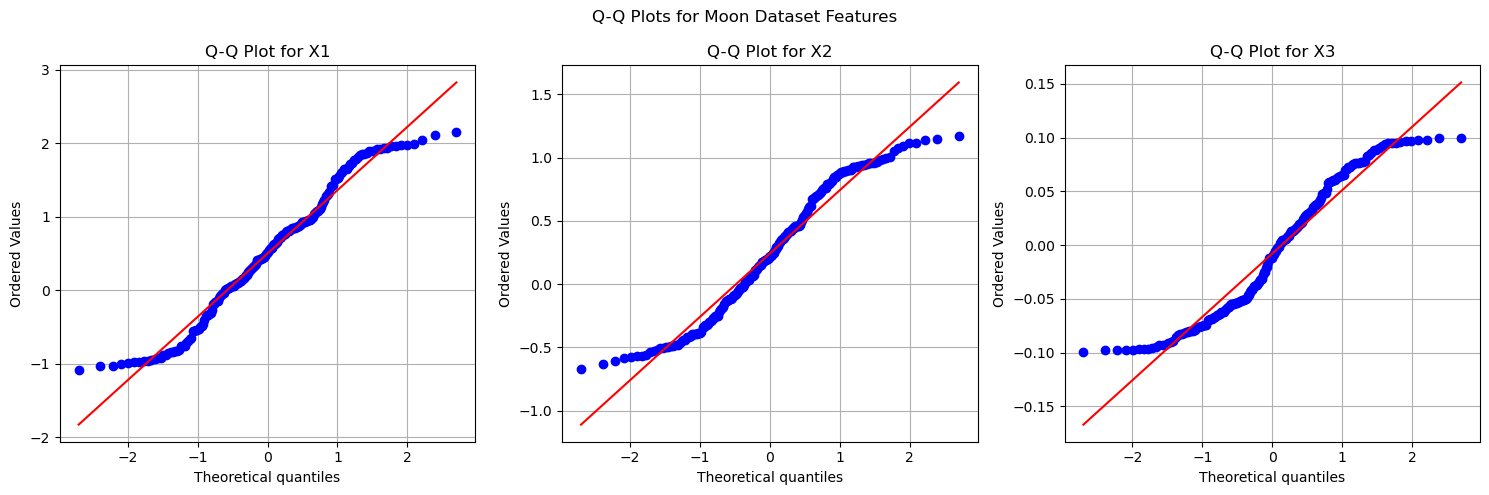


Normality Test Results (Shapiro-Wilk):
--------------------------------------------------
X1:
Statistic: 0.9685
P-value: 0.0002
--------------------------------------------------
X2:
Statistic: 0.9565
P-value: 0.0000
--------------------------------------------------
X3:
Statistic: 0.9398
P-value: 0.0000
--------------------------------------------------


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Read the data
data = pd.read_csv('datasets/moonDataset.csv')

# Create Q-Q plots for each feature
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Q-Q Plots for Moon Dataset Features')

features = ['X1', 'X2', 'X3']

for idx, feature in enumerate(features):
    # Get the data for the current feature
    feature_data = data[feature]
    
    # Create Q-Q plot
    stats.probplot(feature_data, dist="norm", plot=axes[idx])
    
    # Customize the plot
    axes[idx].set_title(f'Q-Q Plot for {feature}')
    axes[idx].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

# Calculate and print additional statistics
print("\nNormality Test Results (Shapiro-Wilk):")
print("-" * 50)
for feature in features:
    statistic, p_value = stats.shapiro(data[feature])
    print(f"{feature}:")
    print(f"Statistic: {statistic:.4f}")
    print(f"P-value: {p_value:.4f}")
    print("-" * 50)

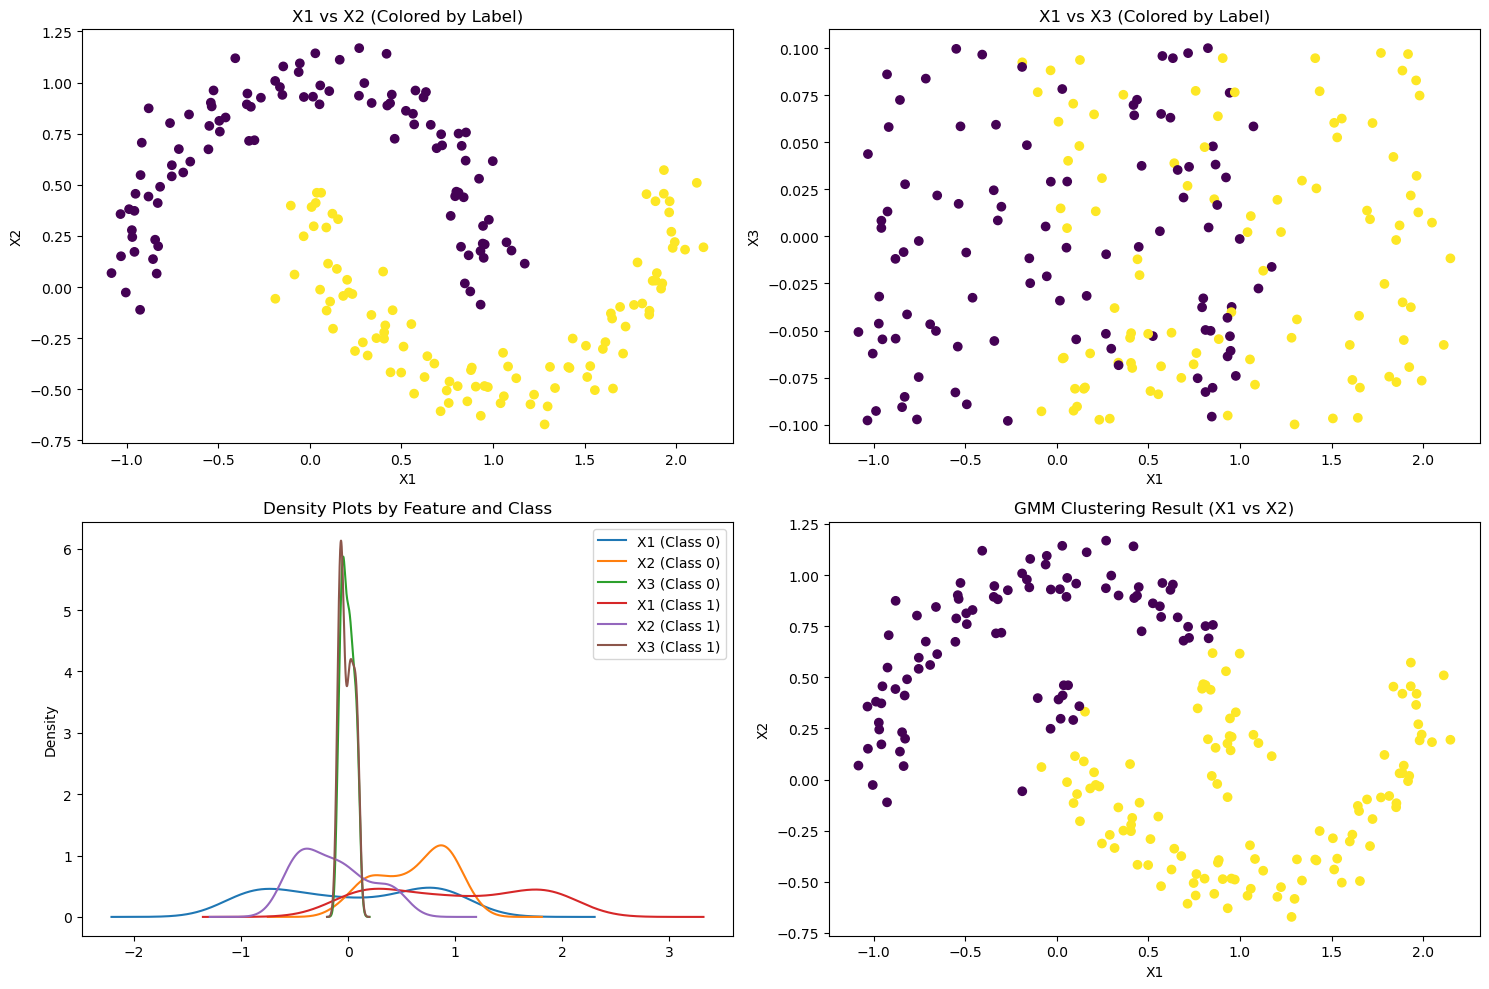


GMM Justification Analysis:
--------------------------------------------------
Hartigan's dip test for X1: 1.2869
Hartigan's dip test for X2: 0.9445
Hartigan's dip test for X3: 1.0414

BIC scores for different numbers of components:
n_components = 1: BIC = 246.28
n_components = 2: BIC = 226.38
n_components = 3: BIC = 202.75
n_components = 4: BIC = 151.13
n_components = 5: BIC = 155.45

Silhouette Score for GMM clustering: 0.4556

Anderson-Darling test for normality within clusters:

Cluster 0:
X1: statistic = 1.3683
X2: statistic = 1.8933
X3: statistic = 1.0332

Cluster 1:
X1: statistic = 1.5085
X2: statistic = 1.2152
X3: statistic = 2.7840


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Read and prepare the data
data = pd.read_csv('datasets/moonDataset.csv')
X = data[['X1', 'X2', 'X3']].values
y = data['label'].values

# 1. Visualize the data distribution
fig = plt.figure(figsize=(15, 10))

# 2D scatter plot with different views
ax1 = fig.add_subplot(221)
ax1.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
ax1.set_title('X1 vs X2 (Colored by Label)')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')

ax2 = fig.add_subplot(222)
ax2.scatter(X[:, 0], X[:, 2], c=y, cmap='viridis')
ax2.set_title('X1 vs X3 (Colored by Label)')
ax2.set_xlabel('X1')
ax2.set_ylabel('X3')

# Density plots for each feature
ax3 = fig.add_subplot(223)
for label in [0, 1]:
    for i, feature in enumerate(['X1', 'X2', 'X3']):
        data[data['label'] == label][feature].plot.density(ax=ax3, 
                                                         label=f'{feature} (Class {label})')
ax3.set_title('Density Plots by Feature and Class')
ax3.legend()

# Fit GMM and plot clusters
ax4 = fig.add_subplot(224)
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(X)
ax4.scatter(X[:, 0], X[:, 1], c=gmm_labels, cmap='viridis')
ax4.set_title('GMM Clustering Result (X1 vs X2)')
ax4.set_xlabel('X1')
ax4.set_ylabel('X2')

plt.tight_layout()
plt.show()

# Statistical tests and metrics
print("\nGMM Justification Analysis:")
print("-" * 50)

# 1. Test for multimodality using Hartigan's dip test
from scipy.stats import median_abs_deviation
def hartigan_dip_test(x):
    mad = median_abs_deviation(x)
    if mad == 0:
        return 0
    return np.mean(np.abs(x - np.median(x))) / mad

for feature in ['X1', 'X2', 'X3']:
    dip_value = hartigan_dip_test(data[feature])
    print(f"Hartigan's dip test for {feature}: {dip_value:.4f}")

# 2. BIC scores for different numbers of components
n_components_range = range(1, 6)
bic = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X)
    bic.append(gmm.bic(X))

print("\nBIC scores for different numbers of components:")
for n, score in zip(n_components_range, bic):
    print(f"n_components = {n}: BIC = {score:.2f}")

# 3. Calculate average silhouette score for GMM clustering
from sklearn.metrics import silhouette_score
gmm = GaussianMixture(n_components=2, random_state=42)
labels = gmm.fit_predict(X)
silhouette_avg = silhouette_score(X, labels)
print(f"\nSilhouette Score for GMM clustering: {silhouette_avg:.4f}")

# 4. Anderson-Darling test for normality within clusters
print("\nAnderson-Darling test for normality within clusters:")
for cluster in [0, 1]:
    cluster_data = X[labels == cluster]
    print(f"\nCluster {cluster}:")
    for i, feature in enumerate(['X1', 'X2', 'X3']):
        stat, crit, sig = stats.anderson(cluster_data[:, i])
        print(f"{feature}: statistic = {stat:.4f}")